# Kexin's analysis on WSLS

In [1]:
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt

from scipy import stats
from datetime import datetime

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Briefly Preprocessing

In [104]:
df=pd.read_csv('../data/m03_gamedata_handcode.csv',index_col=1)
df.columns = df.iloc[7]
df=df[["Game Number","Player",'Arm','Outcome','Time']].iloc[8:,:]
# df

## Separate out each dataframes(diff player & diff game)

In [9]:
df_player1_1=df[(df['Game Number']=='1') & (df['Player']=='1')]
df_player1_2=df[(df['Game Number']=='2') & (df['Player']=='1')]
df_player2_1=df[(df['Game Number']=='1') & (df['Player']=='2')]
df_player2_2=df[(df['Game Number']=='2') & (df['Player']=='2')]
# df_player1_1

Trial Number,Game Number,Player,Arm,Outcome,Time
m03,,,,,
1,1,1,1,1,02:00.906
3,1,1,3,0,02:07.641
5,1,1,2,1,02:13.639
7,1,1,3,0,02:19.068
9,1,1,3,1,02:24.805
...,...,...,...,...,...
191,1,1,3,1,11:14.229
193,1,1,2,1,11:19.859
195,1,1,2,1,11:25.455


## Functions for process and analysis

In [100]:
# calc difference of outcome between trials
def win_lose_outcome(cur_df,col_name):
    cur_df=cur_df.iloc[::-1]
    change_ls=[0]
    ls=cur_df[col_name].tolist()
    ls=[int(i) for i in ls]
    change_ls=np.concatenate((np.diff(ls),change_ls))
    new_col_name=col_name+'Diff'
    cur_df[new_col_name]=change_ls
    cur_df=cur_df.iloc[::-1]
    return cur_df

# label the status for each type
def labeling(outcome_num,num,type_):
    label=''
    num=str(num)
    outcome_num=str(outcome_num)
    if type_=='Outcome':
        if outcome_num=='0':
            label='Loss'
        elif outcome_num=='1':
            label='Win'
    else:
        if num=='0':
            label='Unswitched Arms'
        else:
            label='Switched Arms'
    return label

#similar process of calc differences of arms
def switch_arms(cur_df):
    cur_df=win_lose_outcome(cur_df,'Arm')
    return cur_df['ArmDiff']

def find_df_perCond(cur_df,outStatus,armStatus):
    df_new=cur_df[(cur_df['Outcome_labels']==outStatus)&(cur_df['New_Arms_labels']==armStatus)]
    p=df_new.shape[0]/cur_df.shape[0]*100
    return p
# find prob of each condition (W-Stay, W-Change, L-Stay, L-Change)
def find_prob(cur_df):
    val1=find_df_perCond(cur_df,'Win','Unswitched Arms')
    val2=find_df_perCond(cur_df,'Win','Switched Arms')
    val3=find_df_perCond(cur_df,'Loss','Unswitched Arms')
    val4=find_df_perCond(cur_df,'Loss','Switched Arms')
    return [{"W-S":val1},{"W-C":val2},{"L-S":val3},{"L-C":val4}]


# put the operations into one simple function
def full_operations(cur_df):
    new_df=win_lose_outcome(cur_df,'Outcome')
    new_df['Outcome_labels']=new_df.apply(lambda row: labeling(row['Outcome'],row['OutcomeDiff'], 'Outcome'), axis=1)
    new_df['ArmDiff']=switch_arms(cur_df)
    new_df['Arms_labels']=new_df.apply(lambda row: labeling(row['Outcome'],row['ArmDiff'],'Arm'), axis=1)
    new_arm=new_df['Arms_labels'].tolist()
    new_arm=new_arm[1:]+["End"]
    new_df['New_Arms_labels']=new_arm
    prob_val=find_prob(new_df)
    return prob_val 
#     return new_df # or you can return prob_val for analysing probability

# full_operations(df_player1_1)

## Return probabilities in each case & Plot Bar plot

data passed into plot: [[17.0, 44.0, 9.0, 28.999999999999996], [14.000000000000002, 42.0, 4.0, 39.0], [16.0, 49.0, 7.000000000000001, 27.0], [7.000000000000001, 47.0, 12.0, 33.0]]


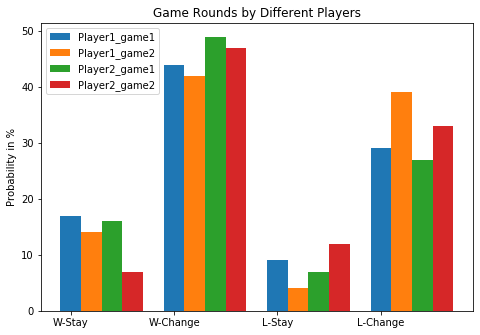

In [101]:
df_lst=[df_player1_1,df_player1_2,df_player2_1,df_player2_2]
prob_lst=[]
for i in df_lst:
    prob_val=full_operations(i)
    prob_lst.append(prob_val)
prob=[e for a in prob_lst for e in a]

numbers=[]
for lst in prob_lst:
    for e in lst:
        val=list(e.values())
        numbers.append(val)
        
flatten = [item for sublist in numbers for item in sublist]#flatten out the list
# from flatten list, create small lists for different player and game
l1=flatten[:4]
l2=flatten[4:8]
l3=flatten[8:12]
l4=flatten[12:]

# pass into plot
data=[l1,l2,l3,l4]
print("data passed into plot:", data)
labels=["W-Stay","W-Change","L-Stay","L-Change"]

X = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], width = 0.2,label='Player1_game1')
ax.bar(X + 0.2, data[1], width = 0.2,label='Player1_game2')
ax.bar(X + 0.40, data[2], width = 0.2,label='Player2_game1')
ax.bar(X + 0.6, data[3], width = 0.2,label='Player2_game2')
fig.tight_layout()
ax.set_ylabel('Probability in %')
ax.set_title('Game Rounds by Different Players')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [102]:
df=pd.DataFrame(data)
df.columns=['Win-Stay','Win-Change','Loss-Stay','Loss-Change']
df.index=['player1_g1','player1_g2','player2_g1','player4_g2']
df

,Win-Stay,Win-Change,Loss-Stay,Loss-Change
player1_g1,17.0,44.0,9.0,29.0
player1_g2,14.0,42.0,4.0,39.0
player2_g1,16.0,49.0,7.0,27.0
player4_g2,7.0,47.0,12.0,33.0


In [103]:
df.mean(axis=0)

Win-Stay       13.5
Win-Change     45.5
Loss-Stay       8.0
Loss-Change    32.0
dtype: float64

## Current insights

WIN-CHANGE has the highest average are most likely due to the uneven portion between win and loss. As far as I know, there are usually more than 70% win rate in a single game, so players would often shift to different holes since they feel like most of the holes would yield a good result (i.e. a fish). 

## Comments for further study

In [ ]:
# you could also try export and further analyse the df's that are returned.
# I did not save them to csv's.